## LASSO example

- [Lassoing the HAR Model: A Model Selection Perspective on Realized Volatility Dynamics](https://www.tandfonline.com/doi/abs/10.1080/07474938.2015.1092801) by Francesci Audrino, Simon D. Knaus

- The HAR (Heterogeneous Autoregressive) model ([Corsi, 2009]  -> 이거 시험에 안나옴 (https://econpapers.repec.org/article/oupjfinec/v_3a7_3ay_3a2009_3ai_3a2_3ap_3a174-196.htm))

    - $logRV^d_{t+1} = \beta_0 + \beta_d logRV^d_{t} + \beta_w logRV^w_{t} + \beta_m logRV^m_{t} + \epsilon_t$ 
    - 변동성예측은 하루전의 변동성, 일주일전의 변동성, 한달전의 변동성으로 설명하면 잘 나온다는 내용
        - $logRV^w_{t} = \sum_{j=0}^4 logRV^d_{t-j}$/5
        - $logRV^m_{t} = \sum_{j=0}^{21} logRV^d_{t-j}$/22
        
    - Even though the HAR model outperforms alternative models, in a statistical point of view the choice of lags is arbitrary.
    - With LASSO, the authors examine whether the lag structure of the HAR model is appropriate.
    - 라소는 시계열 모형을 만들때 AR, MA, ARMA 등 어떤 모형을 만들어야하는 lag를 찾아주는 역할을 하기도 함

#### Data
- [The realized library](https://realized.oxford-man.ox.ac.uk/)

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore')

df = pd.read_csv('data/data.csv', index_col=0, parse_dates=True)
df.head()

,Symbol,rk_twoscale,rk_th2,close_price,rv5,rv5_ss,open_price,rv10,rk_parzen,rsv,medrv,bv_ss,rsv_ss,open_time,rv10_ss,nobs,bv,open_to_close,close_time
2000-01-03 00:00:00+00:00,.AEX,0.000103,0.000102,675.44,0.000130,0.000130,675.67,0.000178,0.000179,0.000046,0.000050,0.000100,0.000046,90101.0,0.000178,1795.0,0.000100,-0.000340,163015.0
2000-01-04 00:00:00+00:00,.AEX,0.000199,0.000201,642.25,0.000201,0.000201,664.20,0.000261,0.000423,0.000147,0.000075,0.000207,0.000147,90416.0,0.000261,1785.0,0.000207,-0.033606,163016.0
2000-01-05 00:00:00+00:00,.AEX,0.000325,0.000345,632.31,0.000491,0.000491,633.37,0.000714,0.000324,0.000328,0.000166,0.000361,0.000328,90016.0,0.000714,1801.0,0.000361,-0.001675,163016.0
2000-01-06 00:00:00+00:00,.AEX,0.000218,0.000221,624.21,0.000225,0.000225,632.46,0.000182,0.000219,0.000116,0.000152,0.000258,0.000116,90016.0,0.000182,1799.0,0.000258,-0.013130,163002.0
2000-01-07 00:00:00+00:00,.AEX,0.000126,0.000123,644.86,0.000138,0.000138,628.93,0.000157,0.000155,0.000048,0.000039,0.000130,0.000048,90046.0,0.000157,1798.0,0.000130,0.025013,163016.0


In [2]:
df.Symbol.unique()

array(['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI',
       '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX',
       '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20',
       '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC',
       '.SSMI', '.STI', '.STOXX50E'], dtype=object)

In [3]:
df = df.loc[df.Symbol == '.KS11']
df.head()

,Symbol,rk_twoscale,rk_th2,close_price,rv5,rv5_ss,open_price,rv10,rk_parzen,rsv,medrv,bv_ss,rsv_ss,open_time,rv10_ss,nobs,bv,open_to_close,close_time
2000-01-04 00:00:00+00:00,.KS11,0.000730,0.000745,1059.04,0.001130,0.001130,1028.33,0.000752,0.000316,0.000413,0.000350,0.000923,0.000413,100100.0,0.000752,363.0,0.000923,0.029427,134129.0
2000-01-05 00:00:00+00:00,.KS11,0.000784,0.000914,987.33,0.000753,0.000753,1006.87,0.001174,0.000697,0.000362,0.000277,0.000947,0.000362,90100.0,0.001174,603.0,0.000947,-0.019597,150029.0
2000-01-06 00:00:00+00:00,.KS11,0.000634,0.000768,960.65,0.000907,0.000907,1013.95,0.001200,0.000937,0.000657,0.000577,0.000971,0.000657,90108.0,0.001200,604.0,0.000971,-0.053999,150100.0
2000-01-07 00:00:00+00:00,.KS11,0.000913,0.001006,951.41,0.001066,0.001066,949.17,0.001314,0.000537,0.000560,0.000481,0.001224,0.000560,90100.0,0.001314,603.0,0.001224,0.002357,150030.0
2000-01-10 00:00:00+00:00,.KS11,0.000238,0.000264,987.24,0.000303,0.000303,979.56,0.000331,0.000183,0.000125,0.000207,0.000296,0.000125,90458.0,0.000331,597.0,0.000296,0.007810,150130.0


In [4]:
df_ = df[['rv5']]
df_.columns = ['rv']
for i in range(1,51):
    df_['rv_'+str(i)] = df_['rv'].shift(i)
df_ = df_.dropna()
df_.head()

,rv,rv_1,rv_2,rv_3,rv_4,rv_5,rv_6,rv_7,rv_8,rv_9,...,rv_41,rv_42,rv_43,rv_44,rv_45,rv_46,rv_47,rv_48,rv_49,rv_50
2000-03-16 00:00:00+00:00,0.000351,0.000362,0.000424,0.000232,0.000269,0.000244,0.000468,0.000382,0.000197,0.000788,...,0.000170,0.000626,0.000406,0.000270,0.000351,0.000303,0.001066,0.000907,0.000753,0.001130
2000-03-17 00:00:00+00:00,0.000238,0.000351,0.000362,0.000424,0.000232,0.000269,0.000244,0.000468,0.000382,0.000197,...,0.000534,0.000170,0.000626,0.000406,0.000270,0.000351,0.000303,0.001066,0.000907,0.000753
2000-03-20 00:00:00+00:00,0.000295,0.000238,0.000351,0.000362,0.000424,0.000232,0.000269,0.000244,0.000468,0.000382,...,0.000391,0.000534,0.000170,0.000626,0.000406,0.000270,0.000351,0.000303,0.001066,0.000907
2000-03-21 00:00:00+00:00,0.000444,0.000295,0.000238,0.000351,0.000362,0.000424,0.000232,0.000269,0.000244,0.000468,...,0.000653,0.000391,0.000534,0.000170,0.000626,0.000406,0.000270,0.000351,0.000303,0.001066
2000-03-22 00:00:00+00:00,0.000300,0.000444,0.000295,0.000238,0.000351,0.000362,0.000424,0.000232,0.000269,0.000244,...,0.000673,0.000653,0.000391,0.000534,0.000170,0.000626,0.000406,0.000270,0.000351,0.000303


In [5]:
# stationary test
from statsmodels.tsa.stattools import adfuller

#p - value를 구하는 것임(낮으면 귀무가설 기각: 단위근이 없고 stationary)
print(adfuller(df_.rv, regression='nc')[1]) 
print(adfuller(df_.rv, regression='c')[1])
print(adfuller(df_.rv, regression='ct')[1])

2.226591044398728e-08
3.385562714170816e-14
4.8648859445854336e-14


<Figure size 432x288 with 0 Axes>

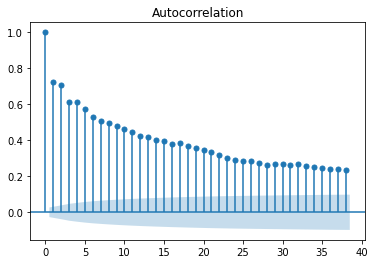

In [6]:
# acf, pacf plot
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

# acf
plt.figure()
plot_acf(df_.rv)
plt.show()

<Figure size 432x288 with 0 Axes>

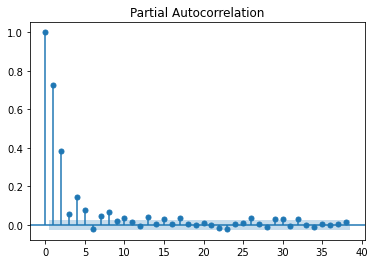

In [7]:
# pacf
plt.figure()
plot_pacf(df_.rv)
plt.show()

In [8]:
# training Lasso
import numpy as np
from sklearn.linear_model import Lasso

y = np.log(df_.rv)
X = np.log(df_.drop('rv', axis=1))
lasso = Lasso(alpha=0.0)
lasso.fit(X,y)

Lasso(alpha=0.0)

In [9]:
lasso.coef_

array([ 3.95466089e-01,  1.93823651e-01,  7.17785545e-02,  6.05298865e-02,
        3.29362523e-02,  5.02273537e-02,  2.24521004e-03,  8.45389935e-03,
        2.35250453e-02,  2.05581587e-02,  4.07308508e-03, -7.09697300e-03,
        2.67614516e-02, -3.75371020e-03,  9.53903651e-03,  8.53094769e-03,
        2.37278542e-02,  6.97806758e-03,  4.68601620e-03, -9.07063504e-03,
       -1.04997216e-02,  3.26961238e-03, -6.12758666e-03,  6.14203061e-03,
       -2.05404543e-02,  6.05972094e-03,  7.12872798e-03,  6.18207406e-03,
        4.60322661e-04, -6.09140968e-03, -2.08994183e-02,  1.97165533e-02,
       -3.94973964e-03,  1.05997292e-02,  1.05066172e-02,  5.07135508e-03,
       -1.46273960e-02,  5.23445396e-02,  2.27845723e-02, -1.51732740e-02,
       -2.47880364e-02, -1.40865139e-02, -4.22159247e-03,  5.54365150e-03,
       -2.71554415e-03, -5.40596029e-05,  1.97478688e-04,  2.42716432e-02,
        1.33686372e-02, -1.37049306e-04])

- Based on this result, can we conclude that only 2 lagged dependent variables are sufficient for realized volatility prediction?
- Of course not.
    - This is only in-sample $\rightarrow$ we need to see if this is generalizble to unseen data (cross-validation)
    - The choice of $\alpha$ is arbitrary (hyperparameter search) 
- Thus, we need to find the best $\alpha$ which delivers the best performance on out-of-sample data.

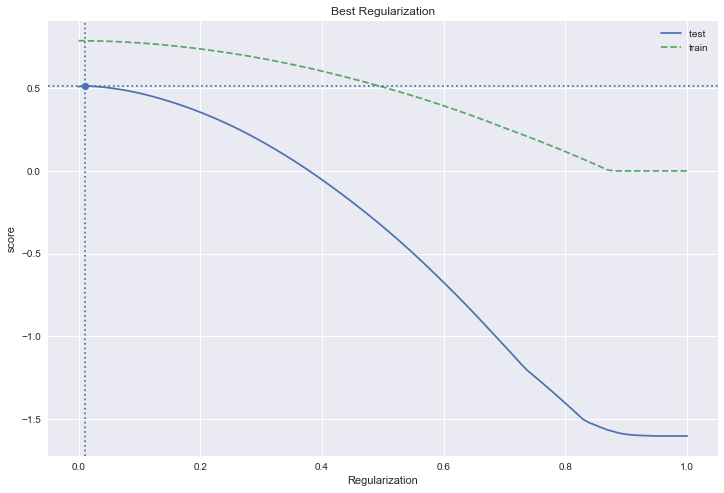

In [10]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # cross-validation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

alphas = np.linspace(0, 1, 100)

train_scores = []
test_scores = []

for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = r2_score(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(model, X, y, scoring="r2", cv=10))
    train_scores.append(train_score)
    test_scores.append(test_score)
optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(alphas, test_scores, "-", label="test ")
plt.plot(alphas, train_scores, "--", label="train")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("Best Regularization")
plt.ylabel('score')
plt.xlabel('Regularization')
plt.legend()
plt.show()

In [11]:
# GridSearchCV 

from sklearn.model_selection import GridSearchCV

alphas = np.linspace(0, 1, 101)
parameters = {'alpha': alphas }
lasso_reg = GridSearchCV(Lasso(), parameters, scoring='r2',cv=10, verbose=2)
lasso_reg.fit(X,y)

Fitting 10 folds for each of 101 candidates, totalling 1010 fits
[CV] END ..........................................alpha=0.0; total time=   0.2s
[CV] END ..........................................alpha=0.0; total time=   0.3s
[CV] END ..........................................alpha=0.0; total time=   0.3s
[CV] END ..........................................alpha=0.0; total time=   0.2s
[CV] END ..........................................alpha=0.0; total time=   0.5s
[CV] END ..........................................alpha=0.0; total time=   0.4s
[CV] END ..........................................alpha=0.0; total time=   0.4s
[CV] END ..........................................alpha=0.0; total time=   0.4s
[CV] END ..........................................alpha=0.0; total time=   0.5s
[CV] END ..........................................alpha=0.0; total time=   0.5s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ...................................

[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .........................................alpha=0.11; total time=   0.0s
[CV] END .........................................alpha=0.11; total time=   0.0s
[CV] END .........................................alpha=0.11; total time=   0.0s
[CV] END .........................................alpha=0.11; total time=   0.0s
[CV] END .........................................alpha=0.11; total time=   0.0s
[CV] END ...................

[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END .........................................alpha=0.21; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.31; total time=   0.0s
[CV] END .........................................alpha=0.31; total time=   0.0s
[CV] END .........................................alpha=0.31; total time=   0.0s
[CV] END .........................................alpha=0.31; total time=   0.0s
[CV] END .........................................alpha=0.31; total time=   0.0s
[CV] END .........................................alpha=0.31; total time=   0.0s
[CV] END .........................................alpha=0.32; total time=   0.0s
[CV] END .........................................alpha=0.32; total time=   0.0s
[CV] END .........................................alpha=0.32; total time=   0.0s
[CV] END .........................................alpha=0.32; total time=   0.0s
[CV] END .........................................alpha=0.32; total time=   0.0s
[CV] END .........................................alpha=0.32; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.42; total time=   0.0s
[CV] END .........................................alpha=0.42; total time=   0.0s
[CV] END .........................................alpha=0.42; total time=   0.0s
[CV] END .........................................alpha=0.42; total time=   0.0s
[CV] END .........................................alpha=0.42; total time=   0.0s
[CV] END .........................................alpha=0.43; total time=   0.0s
[CV] END .........................................alpha=0.43; total time=   0.0s
[CV] END .........................................alpha=0.43; total time=   0.0s
[CV] END .........................................alpha=0.43; total time=   0.0s
[CV] END .........................................alpha=0.43; total time=   0.0s
[CV] END .........................................alpha=0.43; total time=   0.0s
[CV] END .........................................alpha=0.43; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.64; total time=   0.0s
[CV] END .........................................alpha=0.64; total time=   0.0s
[CV] END .........................................alpha=0.64; total time=   0.0s
[CV] END .........................................alpha=0.64; total time=   0.0s
[CV] END .........................................alpha=0.64; total time=   0.0s
[CV] END .........................................alpha=0.65; total time=   0.0s
[CV] END .........................................alpha=0.65; total time=   0.0s
[CV] END .........................................alpha=0.65; total time=   0.0s
[CV] END .........................................alpha=0.65; total time=   0.0s
[CV] END .........................................alpha=0.65; total time=   0.0s
[CV] END .........................................alpha=0.65; total time=   0.0s
[CV] END .........................................alpha=0.65; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.75; total time=   0.0s
[CV] END .........................................alpha=0.75; total time=   0.0s
[CV] END .........................................alpha=0.75; total time=   0.0s
[CV] END .........................................alpha=0.75; total time=   0.0s
[CV] END .........................................alpha=0.75; total time=   0.0s
[CV] END .........................................alpha=0.75; total time=   0.0s
[CV] END .........................................alpha=0.75; total time=   0.0s
[CV] END .........................................alpha=0.76; total time=   0.0s
[CV] END .........................................alpha=0.76; total time=   0.0s
[CV] END .........................................alpha=0.76; total time=   0.0s
[CV] END .........................................alpha=0.76; total time=   0.0s
[CV] END .........................................alpha=0.76; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END .........................................alpha=0.86; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])},
             scoring='r2', verbose=2)

In [12]:
lasso_reg.best_params_

{'alpha': 0.01}

In [13]:
lasso.coef_

array([ 3.95466089e-01,  1.93823651e-01,  7.17785545e-02,  6.05298865e-02,
        3.29362523e-02,  5.02273537e-02,  2.24521004e-03,  8.45389935e-03,
        2.35250453e-02,  2.05581587e-02,  4.07308508e-03, -7.09697300e-03,
        2.67614516e-02, -3.75371020e-03,  9.53903651e-03,  8.53094769e-03,
        2.37278542e-02,  6.97806758e-03,  4.68601620e-03, -9.07063504e-03,
       -1.04997216e-02,  3.26961238e-03, -6.12758666e-03,  6.14203061e-03,
       -2.05404543e-02,  6.05972094e-03,  7.12872798e-03,  6.18207406e-03,
        4.60322661e-04, -6.09140968e-03, -2.08994183e-02,  1.97165533e-02,
       -3.94973964e-03,  1.05997292e-02,  1.05066172e-02,  5.07135508e-03,
       -1.46273960e-02,  5.23445396e-02,  2.27845723e-02, -1.51732740e-02,
       -2.47880364e-02, -1.40865139e-02, -4.22159247e-03,  5.54365150e-03,
       -2.71554415e-03, -5.40596029e-05,  1.97478688e-04,  2.42716432e-02,
        1.33686372e-02, -1.37049306e-04])

In [14]:
import statsmodels.tsa as tsa

res = tsa.ar_model.ar_select_order(y, maxlag=50)

C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [15]:
res.bic

{(1, 2, 3, 4, 5, 6, 7, 8, 9, 10): -1.492349351924436,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): -1.491587489110951,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): -1.4915830625073951,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13): -1.4908682528411785,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): -1.4904345465677753,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14): -1.4895719760369381,
 (1, 2, 3, 4, 5, 6, 7, 8): -1.4894837634931675,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15): -1.4887902380000806,
 (1, 2, 3, 4, 5, 6, 7): -1.4885808969008631,
 (1, 2, 3, 4, 5, 6): -1.488344320712058,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16): -1.4878238533279655,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17): -1.4872290127548082,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18): -1.4857238757506492,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19): -1.484